In [32]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

!pip install contractions
import contractions

In [33]:
from google.colab import files
uploaded = files.upload()

Saving train_stack.csv to train_stack (2).csv


In [34]:
import io
df_train= pd.read_csv(io.BytesIO(uploaded['train_stack.csv']),encoding="ISO-8859-1")

In [35]:
df_train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [36]:
df_train["Y"].unique()

array(['LQ_CLOSE', 'HQ', 'LQ_EDIT'], dtype=object)

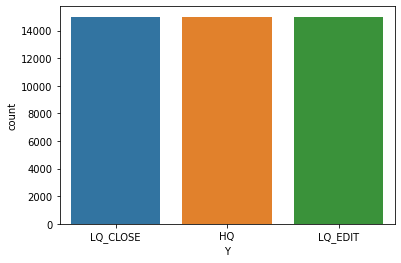

In [37]:
sns.countplot(x="Y",data=df_train)

# **Prétraitement**

In [38]:
df_train["text"]=df_train["Title"] + " " + df_train["Body"]

In [39]:
df_train["text"]

0        Java: Repeat Task Every Random Seconds <p>I'm ...
1        Why are Java Optionals immutable? <p>I'd like ...
2        Text Overlay Image with Darkened Opacity React...
3        Why ternary operator in swift is so picky? <p>...
4        hide/show fab with scale animation <p>I'm usin...
                               ...                        
44995    Convert List<String> to string C# - asp.net - ...
44996    Does Python execute code from the top or botto...
44997    how to change payment date in Azure? <p>It loo...
44998    how to implement fill in the blank in Swift <p...
44999    How can I make a c# application outside of vis...
Name: text, Length: 45000, dtype: object

In [40]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_train["Y"] = encoder.fit_transform(df_train["Y"])

In [41]:
df_train=df_train[["text","Y"]]

In [42]:
#delete duplicates
df_train.dropna(inplace=True)

In [43]:
import re
df_train["text"]=df_train["text"].apply(lambda x: x.lower())
df_train["text"]=df_train["text"].apply(lambda x: contractions.fix(x))
df_train["text"]=df_train["text"].apply(lambda x: re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ', x))

In [44]:
import nltk
nltk.download('wordnet')

def stemming(corpus):
    
    corpus_=""
    
    ps = nltk.stem.porter.PorterStemmer()
    for mot in corpus.split():
        corpus_=corpus_ + " " + ps.stem(mot) + " "
        
    return corpus_

def lemmatisation(corpus):
    corpus_=""
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    for mot in corpus.split():
        corpus_=corpus_ + " " + lem.lemmatize(mot) + " "
    return corpus_

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
import nltk 
from nltk.corpus import stopwords

def remove_stopwords(corpus):
    corpus_=""
    for mot in corpus.split():
        if mot not in stopwords.words('english'):
            corpus_=corpus_ + " " + mot
        else:
            corpus_=corpus_ + " "
    return corpus_


In [46]:
df_train["text"]=df_train["text"].apply(lambda x: stemming(x))
df_train["text"]=df_train["text"].apply(lambda x: lemmatisation(x))

In [47]:
import nltk
nltk.download('stopwords')
  
df_train["text"]=df_train["text"].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tokenization 
vectorizer=TfidfVectorizer(max_features=5000,stop_words='english')
X=vectorizer.fit_transform(df_train["text"])
Y=df_train["Y"]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(36000, 5000) (36000,)
(9000, 5000) (9000,)


# **Modélisation**

In [50]:
lg=LogisticRegression()
lg.fit(X_train,y_train)
y_pred=lg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))

accuracy 0.8204444444444444
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2965
           1       0.80      0.71      0.75      2981
           2       0.81      0.90      0.85      3054

    accuracy                           0.82      9000
   macro avg       0.82      0.82      0.82      9000
weighted avg       0.82      0.82      0.82      9000

Confusion Matrix: 
 [[2525  318  122]
 [ 357 2110  514]
 [  98  207 2749]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [51]:
from sklearn.naive_bayes import MultinomialNB
MB=MultinomialNB()
MB.fit(X_train,y_train)
y_pred=MB.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))

accuracy 0.7454444444444445
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2965
           1       0.68      0.71      0.69      2981
           2       0.81      0.71      0.76      3054

    accuracy                           0.75      9000
   macro avg       0.75      0.75      0.75      9000
weighted avg       0.75      0.75      0.75      9000

Confusion Matrix: 
 [[2432  466   67]
 [ 448 2106  427]
 [ 355  528 2171]]


In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 5000
trunc_type = 'post'
padding_type = 'post'
tokenizer = Tokenizer(num_words=max_features,oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['text'])
list_tokenized_train = tokenizer.texts_to_sequences(df_train['text'])

maxlen = 128
X = pad_sequences(list_tokenized_train, maxlen=maxlen,truncating=trunc_type,padding="post")
Y = df_train['Y']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(36000, 128) (36000,)
(9000, 128) (9000,)


In [54]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional,GlobalMaxPool1D,Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(5000, 128))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        263168    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 903,939
Trainable params: 903,939
Non-tr

In [55]:
epochs = 5
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
225/225 [==============================] - 258s 1s/step - loss: 0.5816 - accuracy: 0.7116 - val_loss: 0.4419 - val_accuracy: 0.7857
Epoch 2/5
225/225 [==============================] - 255s 1s/step - loss: 0.3323 - accuracy: 0.8550 - val_loss: 0.2638 - val_accuracy: 0.8914
Epoch 3/5
225/225 [==============================] - 254s 1s/step - loss: 0.2309 - accuracy: 0.9097 - val_loss: 0.2386 - val_accuracy: 0.9029
Epoch 4/5
225/225 [==============================] - 255s 1s/step - loss: 0.1938 - accuracy: 0.9239 - val_loss: 0.2298 - val_accuracy: 0.9061
Epoch 5/5
225/225 [==============================] - 255s 1s/step - loss: 0.1702 - accuracy: 0.9327 - val_loss: 0.2333 - val_accuracy: 0.9100


# **Performances**

In [56]:
model.evaluate(X_test,y_test)

282/282 [==============================] - 19s 67ms/step - loss: 0.2269 - accuracy: 0.9104


[0.22688274085521698, 0.910444438457489]

In [66]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history):
    
    """
    
    Plot loss and accuracy in order to see if we observe an overfitting
    
    """
    figure = plt.figure(figsize=(10,10))

    # accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'go--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'yo--', label = "val acc")
    
    plt.title("train_acc vs val_acc")
    
   
    #names axis
    plt.xlabel("epcs")
    plt.ylabel("acc")
    plt.legend()

    # loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'go--', label = "loss")
    plt.plot(history.history['val_loss'], 'yo--', label = "val_loss")
    
    plt.title("train_loss vs val_loss")
    
    #names axis
    plt.ylabel("loss")
    plt.xlabel("epcs")

    plt.legend()
    plt.show()

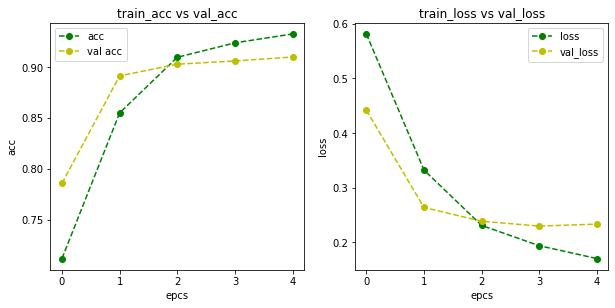

In [58]:
plot_loss_and_accuracy(history)


In [59]:
y_pred = model.predict(X_test)

In [60]:
labels = encoder.classes_

In [61]:
results = pd.DataFrame(data=y_pred,columns=labels)

In [62]:
results

,HQ,LQ_CLOSE,LQ_EDIT
0,0.001523,0.995908,0.002569
1,0.458540,0.541412,0.000048
2,0.000082,0.002927,0.996992
3,0.000012,0.000236,0.999752
4,0.000026,0.000062,0.999912
...,...,...,...
8995,0.000008,0.000226,0.999766
8996,0.020887,0.978050,0.001064
8997,0.000005,0.000106,0.999888
8998,0.000010,0.000138,0.999852


In [63]:
results["Class"]=-1
for id,row in results.iterrows():
  results['Class'].iloc[id] = np.argmax(row)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [64]:
results.Class

0       1
1       1
2       2
3       2
4       2
       ..
8995    2
8996    1
8997    2
8998    2
8999    2
Name: Class, Length: 9000, dtype: int64

In [65]:
print('accuracy %s' % accuracy_score(results.Class,y_test))
print(classification_report(y_test, results.Class))
print('Confusion Matrix: \n',confusion_matrix(y_test,results.Class))

accuracy 0.9104444444444444
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2965
           1       0.86      0.87      0.87      2981
           2       1.00      0.99      0.99      3054

    accuracy                           0.91      9000
   macro avg       0.91      0.91      0.91      9000
weighted avg       0.91      0.91      0.91      9000

Confusion Matrix: 
 [[2576  389    0]
 [ 376 2603    2]
 [   9   30 3015]]
